#(復習) データ読み込みと特徴ベクトルの構築
詳細は第2回の資料を参照してください．

In [ ]:
#データとモジュールの読み込み
import numpy as np
import pandas as pd
# 機械学習のライブラリ．今回は線形回帰LinearRegressionを動かす．
# LinearRegressionはsklearnのlinear_modelモジュールの中にあるので，次のようにインポートする
from sklearn.linear_model import LinearRegression
from google.colab import drive
drive.mount('/content/drive') # google driveをマウント（＝Colabから使えるようにする）
# Google Colabの場合
d_train = pd.read_csv("/content/drive/My Drive/PBL2025/omni2_selected_2000_2024.csv") # 訓練データを読み込む
d_test = pd.read_csv("/content/drive/My Drive/PBL2025/omni2_selected_2025H1_Dst99999.csv") # テストデータを読み込む

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
d_train.header()

In [ ]:
#指定した列だけ取り出す
xlist = [ 'Year', 'Month', 'Day_of_month','Hour[h]', 'B_mag[nT]','Bx_GSE[nT]', 'By_GSM[nT]','Bz_GSM[nT]', 'T_proton[K]', 'N_proton[cm^-3]', 'V_sw[km/s]',
         'Flow_pressure[nPa]', 'E_field[mV/m]', 'Sunspot_num', 'f10.7[sfu]', 'Lyman_alpha[W/m^2]']
         #colabの場合はReturnで改行できる
ylist = ['Dst[nT]']
x_train = d_train[xlist]
y_train = d_train[ylist]
x_test = d_test[xlist]
y_test = d_test[ylist]

#検証データの作成
詳細は第2回の資料を参照してください．

In [ ]:
# 分割前に必ず定義
n_train = len(x_train)
n_valid = int(0.2 * n_train)  # 検証データの数．ラベル付きデータ数n_trainの2割を検証データにする
n_train = n_train - n_valid # 訓練データ数を計算し直す．検証データ以外全てなので，全体（n_train)からn_validationを引く
x_valid = x_train[n_train:] # 現在のX_train_numの後半2割 = 前半8割以降
x_train = x_train[:n_train] # 現在のX_train_numの前半8割．再代入する（変数名を使い回す）

# 目標値も同じように分割する
y_valid = y_train[n_train:]
y_train = y_train[:n_train]

これによって訓練データと検証データに分けられました。

#規則化 (Normalization)
Ridge回帰は 係数の大きさに対してペナルティを課す ため、各特徴量のスケールがそろっていないと不公平になります。

例えば今回の説明変数（特徴量）には「Year」などの 桁の大きい整数 と、「磁場強度 (nT)」「太陽風速度 (km/s)」「プラズマ密度」など単位の異なる特徴量が混ざっています。

標準化せずに Ridge をかけると、大きな値の特徴量が支配的になり、重み付けが歪むため、予測誤差が巨大化します。

そこで、訓練データの特徴量のスケールを統一することが必要です。スケールの統一方法はいくつかありますが、代表的なものとして標準化があげられます。
これは各特徴量を「平均0・標準偏差1」に変換するものです。

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [ ]:
print(x_train_scaled)

[[-1.64730656 -1.60120695 -1.67353276 ...  0.09008939  0.30060346
   0.6968665 ]
 [-1.64730656 -1.60120695 -1.67353276 ...  0.09008939  0.30060346
   0.6968665 ]
 [-1.64730656 -1.60120695 -1.67353276 ...  0.09008939  0.30060346
   0.6968665 ]
 ...
 [ 1.8207541  -1.60120695 -1.67353276 ... -0.92110812 -0.74854598
  -1.02517573]
 [ 1.8207541  -1.60120695 -1.67353276 ... -0.92110812 -0.74854598
  -1.02517573]
 [ 1.8207541  -1.60120695 -1.67353276 ... -0.92110812 -0.74854598
  -1.02517573]]


前回と同じようにalphaの値と検証データとモデルのMSEの関係を調べます。
ただしxとyが両方pandasかnumpyにそろえるようにします。今回はx_train_scaledがnumpyになってしまったので、y=y_trainもnumpyにします。

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# 候補の alpha
alphas = [1e-4,1e-3, 1e-2, 1e-1, 1, 10, 100,1000,10000,100000,1000000,1e7,1e8]

best_alpha = None
best_mse = float("inf") #最初無限にする

for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=True, solver="svd")
    ridge.fit(x_train_scaled, y_train.values)        # 学習(x_trainではなくx_train_scaledになっていることに注意)
    y_pred = ridge.predict(x_valid_scaled)             # テストデータ予測
    mse = mean_squared_error(y_valid, y_pred)   # MSE算出

    print(f"alpha={a}, MSE={mse:.3f}")

    if mse < best_mse:
        best_mse = mse
        best_alpha = a

print("\n最も良い alpha:", best_alpha)
print("そのときの MSE:", best_mse)

alpha=0.0001, MSE=1128.454
alpha=0.001, MSE=1128.454
alpha=0.01, MSE=1128.455
alpha=0.1, MSE=1128.459
alpha=1, MSE=1128.499
alpha=10, MSE=1128.896
alpha=100, MSE=1132.001
alpha=1000, MSE=1128.733
alpha=10000, MSE=1015.129
alpha=100000, MSE=776.207
alpha=1000000, MSE=440.818
alpha=10000000.0, MSE=387.477
alpha=100000000.0, MSE=387.189

最も良い alpha: 100000000.0
そのときの MSE: 387.1888355846254


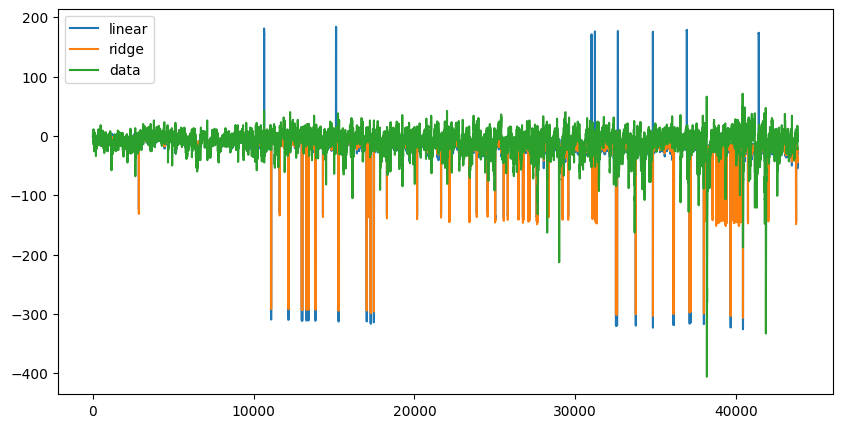

In [ ]:
#モジュールの読み込み
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

# 通常の線形モデルの作成と予測
lr = LinearRegression()# LinearRegressionのインスタンスの作成
lr.fit(x_train, y_train)# 上で作ったオブジェクトの学習
y_pred_valid_lr = lr.predict(x_valid)#　検証データに対する予測

#Ridge回帰モデルの作成と予測
ridge = Ridge(alpha=1e4, fit_intercept=True, solver="svd")  # (for version 1.2.2)
ridge.fit(x_train_scaled, y_train.values)
y_pred_valid_rr = ridge.predict(x_valid_scaled)

import matplotlib.pyplot as plt
xplot = np.arange(n_valid) # 0,1,2...n_valid-1のような配列になる
plt.figure(figsize=(10,5)) #figsize => (x,y)の図のサイズ
plt.plot(xplot,y_pred_valid_lr,label="linear") #label; 凡例の文字
plt.plot(xplot,y_pred_valid_rr,label="ridge") #label; 凡例の文字
plt.plot(xplot,y_valid,label="data")
plt.legend() #凡例を表示
plt.show()

In [ ]:
#テストデータの予測と提出
y_pred_test = ridge.predict(x_test_scaled)
np.savetxt('/content/drive/My Drive/PBL2025/y_pred_ri1.csv', y_pred_test,delimiter=',')